##### 1. загрузка processed и split

In [9]:
import pandas as pd
import plt
from sklearn.model_selection import train_test_split

df = pd.read_csv("../ml/data/processed/hr_processed.csv")
df = df.drop_duplicates()

X = df.drop(columns=["Attrition", "target"])
y = df["target"]
print(f'X.shape: {X.shape}, y.shape: {y.shape}')

row_leave = X[df["target"] == 0].iloc[0].to_dict()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_hash = pd.util.hash_pandas_object(X_train, index=False)
test_hash  = pd.util.hash_pandas_object(X_test, index=False)

print("duplicates across split:", test_hash.isin(train_hash).sum(), "of", len(X_test))

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


X.shape: (23419, 36), y.shape: (23419,)
duplicates across split: 0 of 4684


((18735, 36),
 (4684, 36),
 np.float64(0.1578863090472378),
 np.float64(0.15798462852263023))

##### 2. подготовка признаков

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(exclude="object").columns.tolist()

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols),
])

len(cat_cols), len(num_cols), cat_cols[:5], num_cols[:5]

(9,
 27,
 ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole'],
 ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount'])

##### 3. Утилиты

In [11]:
import json
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def _get_scores(pipe, X):
    if hasattr(pipe, "predict_proba"):
        return pipe.predict_proba(X)[:, 1]
    if hasattr(pipe, "decision_function"):
        return pipe.decision_function(X)
    return pipe.predict(X)


def eval_model(name, pipe, X_test, y_test, threshold=0.5):
    scores = _get_scores(pipe, X_test)
    if hasattr(pipe, "predict_proba"):
        pred = (scores >= threshold).astype(int)
    else:
        pred = (scores >= 0).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

    return {
        "model": name,
        "threshold": threshold if hasattr(pipe, "predict_proba") else 0.0,
        "pr_auc": average_precision_score(y_test, scores),
        "roc_auc": roc_auc_score(y_test, scores),
        "f1": f1_score(y_test, pred),
        "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn),
        "alerts_total": int(tp + fp),
        "caught": f"{int(tp)}/{int(tp+fn)}",
    }

def eval_pipe(name, pipe, X_test, y_test, threshold: float):
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= threshold).astype(int)

    pr_auc = average_precision_score(y_test, proba)
    roc_auc = roc_auc_score(y_test, proba)
    f1 = f1_score(y_test, pred)

    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

    res = {
        "model": name,
        "threshold": float(threshold),
        "pr_auc": float(pr_auc),
        "roc_auc": float(roc_auc),
        "f1": float(f1),
        "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn),
    }

    print(f"\n=== {name} | threshold={threshold:.2f} ===")
    print(classification_report(y_test, pred, digits=4))
    return res

def fit_and_eval(name, model, preprocess, X_train, y_train, X_test, y_test, threshold=0.5):
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    res = eval_model(name, pipe, X_test, y_test, threshold=threshold)
    return res, pipe

def fir_and_eval_tune_hpd(name, model, preprocess, X_train, y_train, X_test, y_test, threshold=0.5):
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    res = eval_model(name, pipe, X_test, y_test, threshold=threshold)
    return res, pipe

def eval_and_plot(name, pipe, X_test, y_test, threshold: float):
    proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} | threshold={threshold:.2f} | accuracy={acc:.4f} ===")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


##### 4. LogReg

In [12]:
from sklearn.linear_model import LogisticRegression

lr_res, lr_pipe = fit_and_eval(
    "LogReg",
    LogisticRegression(max_iter=10000, solver="lbfgs", class_weight="balanced"),
    preprocess, X_train, y_train, X_test, y_test, threshold=0.5
)

pd.DataFrame([lr_res]).round(4)
lr_res

{'model': 'LogReg',
 'threshold': 0.5,
 'pr_auc': 0.3953213640683667,
 'roc_auc': 0.7614309796612027,
 'f1': 0.4125705076551168,
 'tp': 512,
 'fp': 1230,
 'fn': 228,
 'tn': 2714,
 'alerts_total': 1742,
 'caught': '512/740'}

In [13]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

selector = SelectFromModel(
    LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=5000
    )
)

logreg_fs = Pipeline([
    ("prep", preprocess),
    ("fs", selector),
    ("model", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

logreg_fs.fit(X_train, y_train)

preprocess.fit(X_train)
all_feats = preprocess.get_feature_names_out()

mask = logreg_fs.named_steps["fs"].get_support()
print("Всего признаков после one-hot:", len(all_feats))
print("Оставлено после авто-отбора:", int(mask.sum()))

fs_res = eval_model("LogReg+FS(L1)", logreg_fs, X_test, y_test, threshold=0.5)
fs_res


Всего признаков после one-hot: 65
Оставлено после авто-отбора: 53


{'model': 'LogReg+FS(L1)',
 'threshold': 0.5,
 'pr_auc': 0.39564753244282813,
 'roc_auc': 0.7615156104380242,
 'f1': 0.4138765631302945,
 'tp': 513,
 'fp': 1226,
 'fn': 227,
 'tn': 2718,
 'alerts_total': 1739,
 'caught': '513/740'}

##### 5. RandomForest

In [14]:
from sklearn.ensemble import RandomForestClassifier


rf_res, rf_pipe = fit_and_eval(
    "RandomForest",
    RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample",
    ),
    preprocess, X_train, y_train, X_test, y_test, threshold=0.35
)

from pathlib import Path
import joblib

BASE_DIR = Path.cwd().resolve().parent

ARTIFACTS_DIR = BASE_DIR / "ml" / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(rf_pipe, ARTIFACTS_DIR / "model.joblib")

meta = {
    "threshold": 0.35,
    "features": X_train.columns.tolist()
}
joblib.dump(meta, ARTIFACTS_DIR / "meta.joblib")
print("Saved to:", ARTIFACTS_DIR.resolve())

pd.DataFrame([rf_res]).round(4)

proba_rf = rf_pipe.predict_proba(X_test)[:, 1]
rf_results = X_test.copy()
rf_results["prob_leave"] = proba_rf
rf_results["true_label"] = y_test.values
rf_results.sort_values("prob_leave", ascending=False).head(10)
threshold = 0.35
high_risk = rf_results.query("prob_leave >= @threshold")
high_risk_top = high_risk.sort_values("prob_leave", ascending=False).head(10)

high_risk_json = high_risk_top.to_dict(orient="records")

output_path = ARTIFACTS_DIR / "high_risk_employees.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(high_risk_json, f, ensure_ascii=False, indent=2)


Saved to: /home/pydev/Desktop/courses/AI-project/ml/artifacts


In [19]:
# 1️⃣ Проверка переобучения: сравнение train и test
from sklearn.metrics import accuracy_score

# Предсказания для train и test
y_train_pred = rf_pipe.predict(X_train)
y_test_pred = rf_pipe.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))


Train accuracy: 1.0
Test accuracy: 0.9970111016225448


In [21]:
# 2️⃣ Проверка важности признаков
import pandas as pd

# Извлекаем сам RandomForest из пайплайна
rf_model = rf_pipe.steps[-1][1]

# Получаем важности
feat_names = rf_pipe[:-1].get_feature_names_out()
importances = rf_model.feature_importances_

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print("\nTop 15 important features:")
print(feat_imp.head(15))



Top 15 important features:
num__Age                     0.091325
num__DailyRate               0.063378
num__MonthlyIncome           0.053367
num__HourlyRate              0.049726
num__DistanceFromHome        0.047480
num__Application ID          0.046023
num__EmployeeNumber          0.045746
num__MonthlyRate             0.041681
num__TotalWorkingYears       0.036292
num__PercentSalaryHike       0.030183
num__YearsAtCompany          0.030177
num__YearsInCurrentRole      0.025620
num__YearsWithCurrManager    0.024998
num__Education               0.022646
num__StockOptionLevel        0.022580
dtype: float64


In [22]:
# 3️⃣ Проверка устойчивости через кросс-валидацию
from sklearn.model_selection import cross_val_score
import numpy as np

# Оборачиваем в пайплайн
from sklearn.pipeline import Pipeline

cv_pipe = Pipeline([
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(max_depth=10, n_estimators=200, class_weight="balanced", random_state=42))
])

scores = cross_val_score(cv_pipe, X_train, y_train, cv=5, scoring="f1")
print("\nCross-validation F1 scores:", scores)
print("Mean F1:", np.mean(scores))
print("Std F1:", np.std(scores))



Cross-validation F1 scores: [0.94728033 0.9280271  0.9535865  0.91914894 0.93120805]
Mean F1: 0.9358501836322886
Std F1: 0.012703597441613831


##### 6. Boosting

In [15]:
from sklearn.ensemble import HistGradientBoostingClassifier


hgb_res, hgb_pipe = fit_and_eval(
    "HGB",
    HistGradientBoostingClassifier(random_state=42),
    preprocess,
    X_train, y_train, X_test, y_test,
    threshold=0.52
)
pd.DataFrame([hgb_res]).round(4)

,model,threshold,pr_auc,roc_auc,f1,tp,fp,fn,tn,alerts_total,caught
0,HGB,0.52,0.9961,0.9988,0.9323,647,1,93,3943,648,647/740


In [16]:
import numpy as np

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
hgb_pipe.fit(X_tr, y_tr)
proba_val = hgb_pipe.predict_proba(X_val)[:, 1]
hgb_pipe.fit(X_train, y_train)

best_t, best_f1 = None, -1
for t in np.linspace(0.05, 0.95, 91):
    f1 = f1_score(y_val, (proba_val >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_t = f1, t

hgb_tuned_res = eval_pipe(
    "HGB_TUNED", hgb_pipe, X_test, y_test, threshold=best_t
)
hgb_tuned_pipe = hgb_pipe

pd.DataFrame([hgb_res]).round(4)




=== HGB_TUNED | threshold=0.23 ===
              precision    recall  f1-score   support

           0     0.9974    0.9911    0.9943      3944
           1     0.9542    0.9865    0.9701       740

    accuracy                         0.9904      4684
   macro avg     0.9758    0.9888    0.9822      4684
weighted avg     0.9906    0.9904    0.9905      4684



,model,threshold,pr_auc,roc_auc,f1,tp,fp,fn,tn,alerts_total,caught
0,HGB,0.52,0.9961,0.9988,0.9323,647,1,93,3943,648,647/740


###### 7. Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

dt_res, dt_pipe = fit_and_eval(
    "DecisionTree",
    DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced",
        max_depth=8,
        min_samples_leaf=20
    ),
    preprocess, X_train, y_train, X_test, y_test, threshold=0.5
)

pd.DataFrame([dt_res]).round(4)


,model,threshold,pr_auc,roc_auc,f1,tp,fp,fn,tn,alerts_total,caught
0,DecisionTree,0.5,0.6252,0.8857,0.5337,594,892,146,3052,1486,594/740


Сравнение


=== LogReg | threshold=0.50 | accuracy=0.6887 ===
              precision    recall  f1-score   support

           0     0.9225    0.6881    0.7883      3944
           1     0.2939    0.6919    0.4126       740

    accuracy                         0.6887      4684
   macro avg     0.6082    0.6900    0.6004      4684
weighted avg     0.8232    0.6887    0.7289      4684



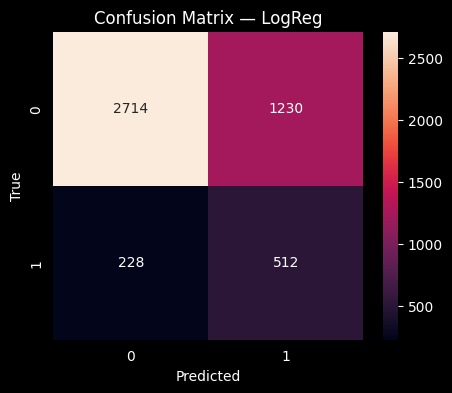


=== RandomForest | threshold=0.35 | accuracy=0.9977 ===
              precision    recall  f1-score   support

           0     0.9972    1.0000    0.9986      3944
           1     1.0000    0.9851    0.9925       740

    accuracy                         0.9977      4684
   macro avg     0.9986    0.9926    0.9956      4684
weighted avg     0.9977    0.9977    0.9976      4684



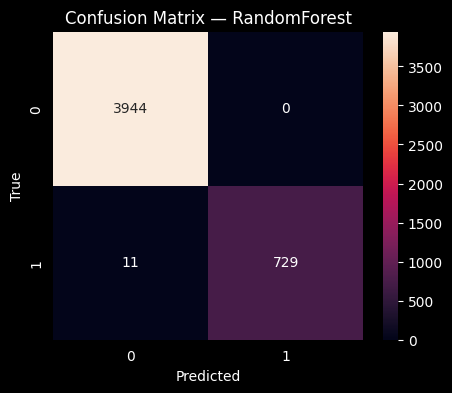


=== HGB | threshold=0.52 | accuracy=0.9799 ===
              precision    recall  f1-score   support

           0     0.9770    0.9997    0.9882      3944
           1     0.9985    0.8743    0.9323       740

    accuracy                         0.9799      4684
   macro avg     0.9877    0.9370    0.9602      4684
weighted avg     0.9804    0.9799    0.9794      4684



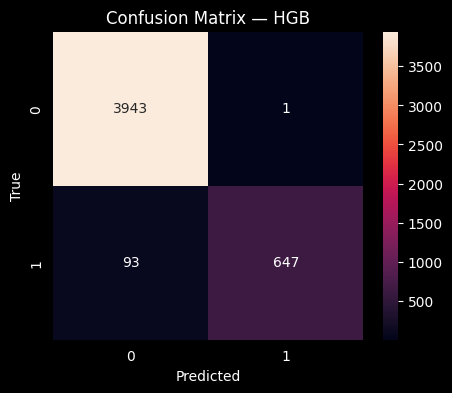


=== HGB_TUNED | threshold=0.23 | accuracy=0.9904 ===
              precision    recall  f1-score   support

           0     0.9974    0.9911    0.9943      3944
           1     0.9542    0.9865    0.9701       740

    accuracy                         0.9904      4684
   macro avg     0.9758    0.9888    0.9822      4684
weighted avg     0.9906    0.9904    0.9905      4684



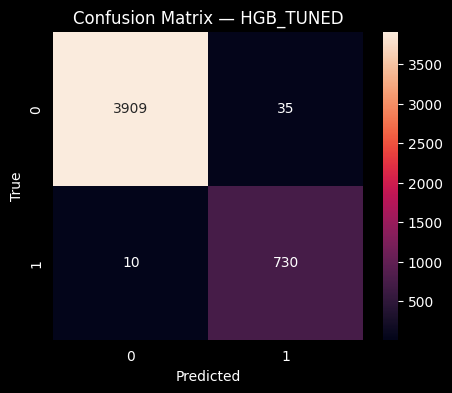


=== DecisionTree | threshold=0.50 | accuracy=0.7784 ===
              precision    recall  f1-score   support

           0     0.9543    0.7738    0.8547      3944
           1     0.3997    0.8027    0.5337       740

    accuracy                         0.7784      4684
   macro avg     0.6770    0.7883    0.6942      4684
weighted avg     0.8667    0.7784    0.8040      4684



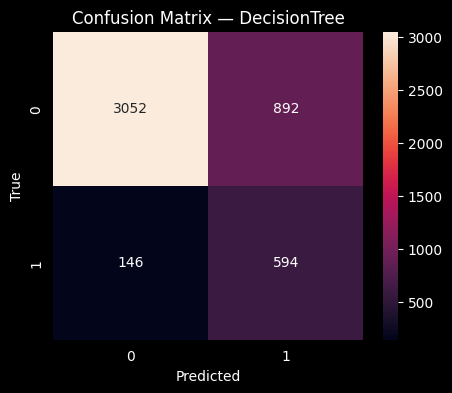

In [18]:
score_table = (pd.DataFrame([lr_res, rf_res, hgb_res, dt_res, hgb_tuned_res])
               .sort_values("pr_auc", ascending=False)
               .round(4))

score_table

models = {
    "LogReg": (lr_pipe, float(lr_res["threshold"])),
    "RandomForest": (rf_pipe, float(rf_res["threshold"])),
    "HGB": (hgb_pipe, float(hgb_res["threshold"])),
    "HGB_TUNED": (hgb_tuned_pipe, float(hgb_tuned_res["threshold"])),
    "DecisionTree": (dt_pipe, float(dt_res["threshold"])),
}

for name, (pipe, thr) in models.items():
    eval_and_plot(name, pipe, X_test, y_test, thr)
